In [1]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L

Populating the interactive namespace from numpy and matplotlib


In [20]:
train_feats = pa.read_csv('full3_train_feats.csv')
train_targets = pa.read_csv('full3_train_targets.csv')
# val_feats = pa.read_csv('validation_feats.csv')
# val_targets = pa.read_csv('validation_targets.csv')
vval_feats = pa.read_csv('val3_train_feats.csv')
vval_targets = pa.read_csv('val3_train_targets.csv')

In [21]:
tx = np.asarray(train_feats, dtype=np.float32)
tyall = np.asarray(train_targets, dtype=np.float32)
ty = np.asarray(train_targets['LABEL'], dtype=np.float32).reshape(-1, 1)
# vx = np.asarray(val_feats, dtype=np.float32)
# vyall = np.asarray(val_targets, dtype=np.float32)
# vy = np.asarray(val_targets['LABEL'], dtype=np.float32).reshape(-1, 1)

In [22]:
tlabels = np.asarray(pa.read_csv('Training_Dataset/id_label_train.csv'))

In [23]:
valx = np.asarray(vval_feats, dtype=np.float32)
valyall = np.asarray(vval_targets, dtype=np.int64)

In [24]:
ty = ty.ravel()
# vy = vy.ravel()

In [25]:
print tx.shape, tyall.shape, ty.shape #, vx.shape, vyall.shape, vy.shape

(628437, 129) (628437, 4) (628437,)


In [26]:
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [39]:
clf = svm.SVC(verbose=True, max_iter=200, class_weight={0:1, 1:1})
clf.fit(tx, ty)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight={0: 10, 1: 1}, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=200, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=True)

In [40]:
tprobs = clf.decision_function(tx)
# vprobs = clf.decision_function(vx)
# valprobs = clf.decision_function(valx)

In [41]:
num_examples = tx.shape[0]
maxs = np.asarray([nan for j in xrange(tlabels.shape[0])])
for j in xrange(num_examples):
    ind = tyall[j,0]-1
    maxs[ind] = np.nanmax((maxs[ind], tprobs[j]))

thresh = np.percentile(maxs, 99)

maxs = np.int32(maxs>=thresh)

tp = 0
fp = 0
tn = 0
fn = 0
for j in xrange(maxs.shape[0]):
    if maxs[j] == 1:
        if tlabels[j,1] == 1:
            tp += 1
        else:
            fp += 1
    else:
        if tlabels[j,1] == 0:
            tn += 1
        else:
            fn += 1

print tp, tn, fp, fn
print 'sensitivity = ', tp*1.0/(tp+fn)
print 'specificity = ', tn*1.0/(tn+fp)
sys.stdout.flush()

4 3317 32 241
sensitivity =  0.0163265306122
specificity =  0.990444908928


0.338434611676


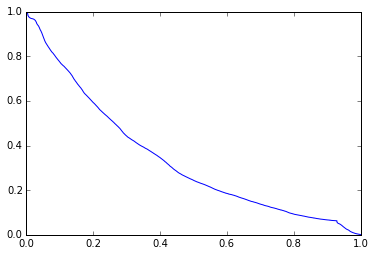

In [42]:
yscore = tprobs.ravel()
fpr, tpr, thresh = roc_curve(ty, yscore)
auc = roc_auc_score(ty, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

# yscore = vprobs.ravel()
# fpr, tpr, thresh = roc_curve(vy, yscore)
# auc = auc_score(vy, yscore)
# print auc
# display(pyplot.plot(1-fpr, tpr,))

In [21]:
# thresh = np.percentile(valprobs.ravel(), 99.7)
thresh = 0.7590
print thresh
pred = np.int32(valprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+',1\n')
outfile.close()

0.759
1468


In [46]:
print np.percentile(valprobs.ravel(), 99.5)
print np.percentile(valprobs.ravel(), 99.3)

0.759480724715
0.759055356111


In [22]:
# thresh = np.percentile(valprobs.ravel(), 99.3)
thresh = 0.7590
print thresh
pred = np.int32(valprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('output.csv', 'w')
# outfile.write('ID,TIME,LABEL\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+'\n')
outfile.close()

0.759
1468


In [23]:
reload(V)
V.validate('out.csv', './Validation_Data/id_label_val.csv')

tp :  14 , tn :  1111 , fp :  5 , fn :  68
sensitivity :  0.170731707317 , specificity :  0.995519713262
accuracy :  0.939065108514 median prediction time :  93.6519444444
finalScore :  35.5647346796


(0.17073170731707318,
 0.9955197132616488,
 0.9390651085141903,
 93.651944444444439,
 35.56473467960488)